# lm_head Geometry Analysis

**Goal:** Automated analysis of any model's lm_head embedding matrix and its causal metric tensor.

**What this notebook does:**
1. Load a model and extract its unembedding matrix γ (lm_head.weight)
2. Compute the causal metric tensor M = Cov(γ)⁻¹
3. Analyze the eigenvalue spectrum and geometric properties
4. Produce summary statistics and visualizations

**Key metrics:**
- **Eigenvalue spectrum:** Which directions are stretched vs compressed?
- **Condition number:** Ratio of max to min eigenvalue (anisotropy measure)
- **Effective dimensionality:** What % of dimensions contain real structure?
- **Frobenius norm:** How different is this from Euclidean space?

**Usage:** Change MODEL_NAME in the config cell, then run all cells.

## Configuration

In [19]:
# ============================================
# MODEL TO ANALYZE
MODEL_NAME = 'google/gemma-3-4b-it'
# Try: 'gpt2', 'gpt2-medium', 'gpt2-large'
#      'meta-llama/Llama-2-7b-hf'
#      'google/gemma-2b'
# ============================================

# Regularization for matrix inversion
REGULARIZATION = 1e-6  # Tikhonov regularization: Cov(γ) + λI

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Regularization: {REGULARIZATION}")

Configuration:
  Model: google/gemma-3-4b-it
  Regularization: 1e-06


## Setup

In [20]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt
from datetime import datetime
import gc

print("✓ Imports complete")

✓ Imports complete


## Load Model and Extract lm_head

In [21]:
print("=" * 80)
print("LOADING MODEL")
print("=" * 80)

print(f"\nLoading {MODEL_NAME}...")
print("  This may take 1-2 minutes...\n")

start_time = datetime.now()

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map='cpu',
)

load_time = (datetime.now() - start_time).total_seconds()

print(f"✓ Model loaded in {load_time:.1f} seconds\n")

# Extract unembedding matrix
print("Extracting lm_head.weight (unembedding matrix γ)...")
gamma = model.lm_head.weight.data.to(torch.float32).cpu()

vocab_size, hidden_dim = gamma.shape

print(f"\n✓ Extracted γ")
print(f"  Vocabulary size: {vocab_size:,}")
print(f"  Hidden dimension: {hidden_dim:,}")
print(f"  Matrix shape: {gamma.shape}")
print(f"  Memory: {gamma.element_size() * gamma.nelement() / 1e9:.2f} GB")

# Free up model memory
print("\nDeleting model to free memory...")
del model
gc.collect()
print("✓ Model deleted")

LOADING MODEL

Loading google/gemma-3-4b-it...
  This may take 1-2 minutes...



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded in 0.6 seconds

Extracting lm_head.weight (unembedding matrix γ)...

✓ Extracted γ
  Vocabulary size: 262,208
  Hidden dimension: 2,560
  Matrix shape: torch.Size([262208, 2560])
  Memory: 2.69 GB

Deleting model to free memory...
✓ Model deleted


## Compute Covariance Matrix

In [22]:
print("\n" + "=" * 80)
print("COMPUTING COVARIANCE MATRIX")
print("=" * 80)

print(f"\nComputing Cov(γ)...")
print(f"  Formula: Cov(γ) = (1/V) Σ (γᵢ - μ)(γᵢ - μ)ᵀ")

start_time = datetime.now()

# Center the data
gamma_centered = gamma - gamma.mean(dim=0, keepdim=True)

# Compute covariance: (1/N) X^T X
cov_gamma = (gamma_centered.T @ gamma_centered) / vocab_size

cov_time = (datetime.now() - start_time).total_seconds()

print(f"✓ Covariance computed in {cov_time:.1f} seconds")
print(f"  Shape: {cov_gamma.shape}")
print(f"  Memory: {cov_gamma.element_size() * cov_gamma.nelement() / 1e6:.1f} MB")


COMPUTING COVARIANCE MATRIX

Computing Cov(γ)...
  Formula: Cov(γ) = (1/V) Σ (γᵢ - μ)(γᵢ - μ)ᵀ
✓ Covariance computed in 1.1 seconds
  Shape: torch.Size([2560, 2560])
  Memory: 26.2 MB


## Compute Metric Tensor M = Cov(γ)⁻¹

In [ ]:
print("\n" + "=" * 80)
print("COMPUTING CAUSAL METRIC TENSOR")
print("=" * 80)

print(f"\nApplying Tikhonov regularization...")
print(f"  Cov(γ) + {REGULARIZATION}·I")
cov_gamma_reg = cov_gamma + REGULARIZATION * torch.eye(hidden_dim)

print(f"\nComputing inverse: M = Cov(γ)⁻¹...")
print(f"  This will take 1-2 minutes...\n")

start_time = datetime.now()

M = torch.linalg.inv(cov_gamma_reg)

inv_time = (datetime.now() - start_time).total_seconds()

print(f"✓ Metric tensor computed in {inv_time:.1f} seconds")
print(f"  Shape: {M.shape}")

# Verify symmetry
symmetry_error = (M - M.T).abs().max().item()
print(f"\nSymmetry check:")
print(f"  Max |M - Mᵀ|: {symmetry_error:.2e}")
if symmetry_error < 1e-5:
    print(f"  ✓ Matrix is symmetric")
else:
    print(f"  ⚠️  Symmetry error detected")


COMPUTING CAUSAL METRIC TENSOR

Applying Tikhonov regularization...
  Cov(γ) + 1e-06·I

Computing inverse: M = Cov(γ)⁻¹...
  This will take 1-2 minutes...

✓ Metric tensor computed in 0.0 seconds
  Shape: torch.Size([2560, 2560])

Symmetry check:
  Max |M - Mᵀ|: 2.94e-02
  ⚠️  Symmetry error detected


## Eigendecomposition

In [ ]:
print("\n" + "=" * 80)
print("COMPUTING EIGENDECOMPOSITION")
print("=" * 80)

print(f"\nComputing eigenvalues and eigenvectors...")
print(f"  M = V Λ Vᵀ")

start_time = datetime.now()

eigenvalues, eigenvectors = torch.linalg.eigh(M)

eig_time = (datetime.now() - start_time).total_seconds()

print(f"✓ Eigendecomposition computed in {eig_time:.1f} seconds")
print(f"  Eigenvalues shape: {eigenvalues.shape}")
print(f"  Eigenvectors shape: {eigenvectors.shape}")

# Convert to numpy for analysis
eigenvalues_np = eigenvalues.numpy()

print(f"\nEigenvalue statistics:")
print(f"  Min: {eigenvalues_np.min():.2f}")
print(f"  Max: {eigenvalues_np.max():.2f}")
print(f"  Mean: {eigenvalues_np.mean():.2f}")
print(f"  Median: {np.median(eigenvalues_np):.2f}")


COMPUTING EIGENDECOMPOSITION

Computing eigenvalues and eigenvectors...
  M = V Λ Vᵀ
  This will take 1-2 minutes...

✓ Eigendecomposition computed in 0.4 seconds
  Eigenvalues shape: torch.Size([2560])
  Eigenvectors shape: torch.Size([2560, 2560])

Eigenvalue statistics:
  Min: 40.52
  Max: 17430.29
  Mean: 3193.57
  Median: 3099.44


## Geometric Properties

In [25]:
print("\n" + "=" * 80)
print("GEOMETRIC PROPERTIES")
print("=" * 80)

# 1. Condition number
condition_number = eigenvalues_np.max() / eigenvalues_np.min()
print(f"\n1. CONDITION NUMBER: {condition_number:.2f}")
print(f"   (Ratio of max to min eigenvalue)")
print(f"   Interpretation: Most stretched direction is {condition_number:.0f}× more")
print(f"   stretched than most compressed direction.")

# 2. Effective dimensionality (participation ratio)
sum_lambda = eigenvalues_np.sum()
sum_lambda_sq = (eigenvalues_np ** 2).sum()
participation_ratio = (sum_lambda ** 2) / sum_lambda_sq
effective_dim_pct = 100 * participation_ratio / hidden_dim

print(f"\n2. EFFECTIVE DIMENSIONALITY: {participation_ratio:.0f} / {hidden_dim} ({effective_dim_pct:.1f}%)")
print(f"   (Participation ratio: (Σλᵢ)² / Σ(λᵢ²))")
print(f"   Interpretation: Only {effective_dim_pct:.1f}% of dimensions contain")
print(f"   significant variance. The rest is noise.")

# 3. Frobenius norm (distance from Euclidean)
identity = torch.eye(hidden_dim)
frobenius_norm = torch.norm(M - identity, p='fro').item()
frobenius_pct = 100 * frobenius_norm / torch.norm(identity, p='fro').item()

print(f"\n3. DISTANCE FROM EUCLIDEAN: {frobenius_norm:.2f}")
print(f"   (Frobenius norm: ||M - I||_F)")
print(f"   Relative to identity: {frobenius_pct:.0f}%")
print(f"   Interpretation: Metric tensor is {frobenius_pct:.0f}% different")
print(f"   from Euclidean space (identity matrix).")

# 4. Determinant (volume scaling)
# Note: Log determinant to avoid overflow
log_det = torch.logdet(M).item()
print(f"\n4. LOG DETERMINANT: {log_det:.2f}")
print(f"   (log(det(M)) = Σ log(λᵢ))")
print(f"   Interpretation: Metric inflates volumes by factor of e^{log_det:.0f}.")
print(f"   (Astronomically huge volume expansion!)")


GEOMETRIC PROPERTIES

1. CONDITION NUMBER: 430.20
   (Ratio of max to min eigenvalue)
   Interpretation: Most stretched direction is 430× more
   stretched than most compressed direction.

2. EFFECTIVE DIMENSIONALITY: 2231 / 2560 (87.2%)
   (Participation ratio: (Σλᵢ)² / Σ(λᵢ²))
   Interpretation: Only 87.2% of dimensions contain
   significant variance. The rest is noise.

3. DISTANCE FROM EUCLIDEAN: 172745.52
   (Frobenius norm: ||M - I||_F)
   Relative to identity: 341418%
   Interpretation: Metric tensor is 341418% different
   from Euclidean space (identity matrix).

4. LOG DETERMINANT: 20480.41
   (log(det(M)) = Σ log(λᵢ))
   Interpretation: Metric inflates volumes by factor of e^20480.
   (Astronomically huge volume expansion!)


## Eigenvalue Spectrum Visualization


CREATING EIGENVALUE SPECTRUM PLOT


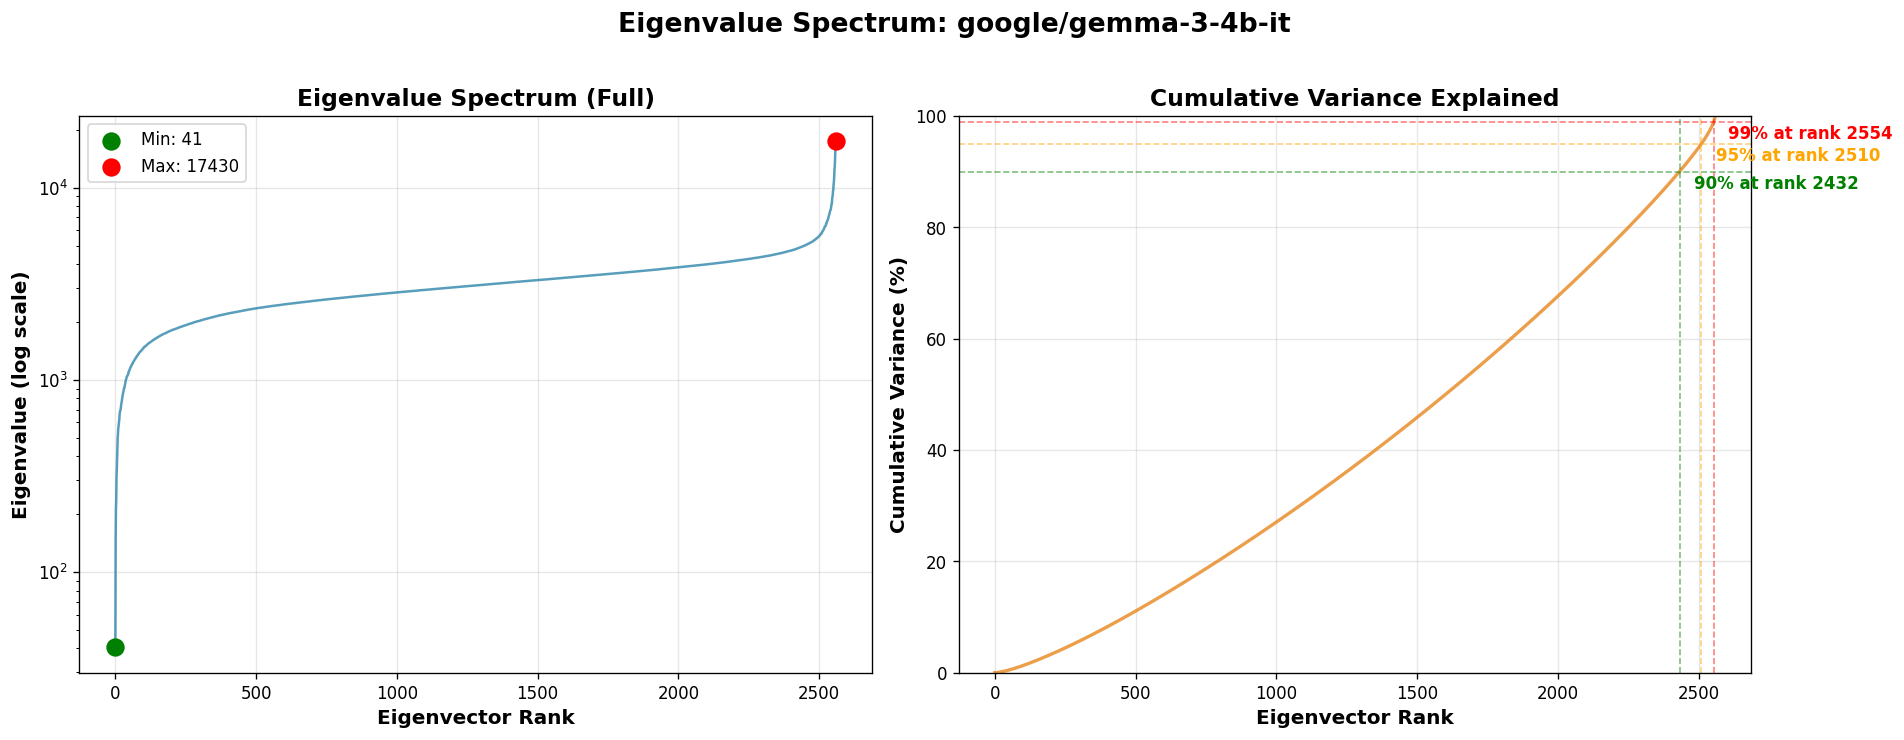


✓ Plot created


In [26]:
print("\n" + "=" * 80)
print("CREATING EIGENVALUE SPECTRUM PLOT")
print("=" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=120)

# Left plot: Full spectrum (log scale)
ranks = np.arange(hidden_dim)
ax1.plot(ranks, eigenvalues_np, linewidth=1.5, color='#2E86AB', alpha=0.8)
ax1.set_xlabel('Eigenvector Rank', fontsize=12, fontweight='bold')
ax1.set_ylabel('Eigenvalue (log scale)', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.set_title('Eigenvalue Spectrum (Full)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add annotations for extremes
ax1.scatter([0], [eigenvalues_np[0]], color='green', s=100, zorder=10, 
            label=f'Min: {eigenvalues_np[0]:.0f}')
ax1.scatter([hidden_dim-1], [eigenvalues_np[-1]], color='red', s=100, zorder=10,
            label=f'Max: {eigenvalues_np[-1]:.0f}')
ax1.legend()

# Right plot: Cumulative variance
cumsum = np.cumsum(eigenvalues_np) / eigenvalues_np.sum()
ax2.plot(ranks, cumsum * 100, linewidth=2, color='#E8871E', alpha=0.8)
ax2.set_xlabel('Eigenvector Rank', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Variance (%)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

# Mark 90%, 95%, 99% thresholds
for threshold, color in [(90, 'green'), (95, 'orange'), (99, 'red')]:
    idx = np.searchsorted(cumsum * 100, threshold)
    ax2.axhline(threshold, color=color, linestyle='--', linewidth=1, alpha=0.5)
    ax2.axvline(idx, color=color, linestyle='--', linewidth=1, alpha=0.5)
    ax2.text(idx + 50, threshold - 3, f'{threshold}% at rank {idx}', 
             fontsize=10, color=color, fontweight='bold')

plt.suptitle(f'Eigenvalue Spectrum: {MODEL_NAME}', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Plot created")

## Summary

In [27]:
print("\n" + "=" * 80)
print(f"SUMMARY: {MODEL_NAME}")
print("=" * 80)

print(f"\nModel Properties:")
print(f"  Vocabulary size: {vocab_size:,}")
print(f"  Hidden dimension: {hidden_dim:,}")
print(f"  Embedding matrix size: {gamma.element_size() * gamma.nelement() / 1e9:.2f} GB")

print(f"\nGeometric Properties:")
print(f"  Condition number: {condition_number:.2f}")
print(f"  Effective dimensionality: {participation_ratio:.0f} / {hidden_dim} ({effective_dim_pct:.1f}%)")
print(f"  Distance from Euclidean: {frobenius_pct:.0f}%")
print(f"  Log determinant: {log_det:.2f}")

print(f"\nEigenvalue Range:")
print(f"  Min: {eigenvalues_np.min():.2f}")
print(f"  Max: {eigenvalues_np.max():.2f}")
print(f"  Ratio: {condition_number:.0f}×")

print(f"\nComputation Time:")
print(f"  Model loading: {load_time:.1f}s")
print(f"  Covariance: {cov_time:.1f}s")
print(f"  Inversion: {inv_time:.1f}s")
print(f"  Eigendecomposition: {eig_time:.1f}s")
print(f"  Total: {load_time + cov_time + inv_time + eig_time:.1f}s")

print("\n" + "=" * 80)


SUMMARY: google/gemma-3-4b-it

Model Properties:
  Vocabulary size: 262,208
  Hidden dimension: 2,560
  Embedding matrix size: 2.69 GB

Geometric Properties:
  Condition number: 430.20
  Effective dimensionality: 2231 / 2560 (87.2%)
  Distance from Euclidean: 341418%
  Log determinant: 20480.41

Eigenvalue Range:
  Min: 40.52
  Max: 17430.29
  Ratio: 430×

Computation Time:
  Model loading: 0.6s
  Covariance: 1.1s
  Inversion: 0.0s
  Eigendecomposition: 0.4s
  Total: 2.1s



---

## Next Steps

**What we've computed:**
- Causal metric tensor M = Cov(γ)⁻¹
- Full eigendecomposition: 2,560 eigenvalues and eigenvectors
- Summary statistics: condition number, effective dimensionality, etc.

**What you can do with this:**
- Compare different models (change MODEL_NAME and re-run)
- Analyze specific eigenvectors (which tokens align with them?)
- Project steering vectors onto this eigenbasis
- Measure token distortions (causal vs Euclidean norms)
- Explore cross-sectional geometry (token cloud extent along eigenvectors)

**Ready for deeper analysis!** 🚀